Dans ce Notebook, j'ai testé deux méthodes pour déterminer l'appartenance d'un point à la zone des Résidences, comprenant Comparat et Adoma.
- La méthode du "Rectangle"
- La méthode de "Pénalisation"

Raphaël Chalicarne
21/03/18
PE 35

# Méthode Rectangle

On récupère les coordonnées GPS de quatre points A,B,C et D pour définir un polygone. On veut coder une fonction qui détermine si un point est dans ce polygone ou non.

<img src="residence.png"/>

In [1]:
# Quelques imports
import json
import pandas as pd
import matplotlib.pyplot as plt
import time as t
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
import matplotlib.cbook as cbook

#Lecture du fichier
file = "Historique des positions raphael 140318.json"
df = pd.read_json(file)
#print(df)

donnee=df.get("locations")
#print(donnee)

#Récupération des latitudes, longitudes et des dates
lat=[]
long=[]
temps=[]

for i in range(len(donnee)):
    lat.append(donnee[i]["latitudeE7"]/1e7)
    long.append(donnee[i]["longitudeE7"]/1e7)
    temps.append(donnee[i]["timestampMs"])

def conv(temps):
    """Ce programme permet de convertir la liste des temps (de type string) en une liste des temps de type float, également utilisable par le module time"""
    n = len(temps)
    liste = [0]*n
    for i in range(n):
        t0 = 0.001*float(temps[i])
        liste[i]=t0
    return liste

temps = conv(temps)

Récupération des données GPS de GoogleMaps (les mesures sont plus précises)

In [2]:
X = [4.77057,45.78253] #Point dans le batiment X
S = [4.76890,45.78321] #Point sur le stade
ES = [4.770143,45.782626] #Extrémité stade

#Mesures Google Maps
A = [4.770862,45.783566]
B = [4.771527,45.783438]
C = [4.770218,45.781155]
D = [4.769370,45.781364]

On définit un programme donnant le coefficient directeur a et l'ordonnée à l'origine b d'une fonction affine de la forme y = a*x + b, à partir de deux points appartenant à la droite.

In [11]:
def param_affine(pointA,pointB):
    x1 = pointA[0]
    x2 = pointB[0]
    y1 = pointA[1]
    y2 = pointB[1]
    a = (y2-y1)/(x2-x1)
    b = (x2*y1-x1*y2)/(x2-x1)
    return a,b

On récupère les coordonnées des droites C1, C2, C3 et C4.

In [12]:
C1 = param_affine(A,B)
C2 = param_affine(B,C)
C3 = param_affine(C,D)
C4 = param_affine(D,A)

a1, b1 = C1
a2, b2 = C2
a3, b3 = C3
a4, b4 = C4

On définit alors la fonction is_in_Residence(point) qui renvoie un booléen selon que le point considéré soit dans le polygone ABCD ou non.

In [16]:
def is_in_Residence(point):
    """Entrée : point =[x,y]"""
    x, y = point
    yC1 = a1*x + b1
    yC2 = a2*x + b2
    yC3 = a3*x + b3
    yC4 = a4*x + b4
    if yC1>y>yC3 and yC4>y>yC2:
        return True
    else:
        return False

Ce programme ne fonctionne pas à cause d'incertitudes sur les coordonnées GPS de chaque point. En effet, en calculant les coefficients directeurs, on effectue une division par des coordonnées très proches, ce qui cause une grosse incertitude.

In [18]:
print("Le point X est dans la zone des résidences :",is_in_Residence(X))
print("Le point S est sur le stade, en dehors de la zone des résidences :",is_in_Residence(S))

Le point X est dans la zone des résidences : False
Le point S est sur le stade, en dehors de la zone des résidences : False


In [19]:
yC1 = a1*X[0] + b1
yC2 = a2*X[0] + b2
yC3 = a3*X[0] + b3
yC4 = a4*X[0] + b4
print("On devrait avoir",yC1," < ",X[1]," < ",yC3, "et",yC4," < ",X[1]," < ",yC2)

On devrait avoir 45.78244513454467  <  45.78253  <  45.781068245261444 et 45.782732224294406  <  45.78253  <  45.78072245759288


# Méthode Pénalisation

Dans cette méthode, on mesure la distance d'un point à un segment caractéristique de la zone des résidences, pour déterminer si ce point est dans la zone ou non.

<img src="residence2.png"/>

Coordonnées des points A et B et détermination de l'équation caractéristique de la droite (AB).

In [20]:
A = [4.771082,45.783316]
B = [4.769982,45.781445] #Coordonnées du segment caractéristique de la résidence.
#cf Schéma Résidence2.png
a,b = param_affine(A,B)
c = -1/a

On propose alors une nouvelle fonction qui à partir d'une distance r0 considère que le point fait ou non partie de la zone des résidences.
Cette fonction est à améliorer pour prendre en compte les extrémités de la zone des résidences.

In [21]:
def is_in_Residence2(point):
    """point = [x,y]"""
    x,y = point
    d = y-c*x
    x0 = (d-b)/(a-c)
    y0 = a*x0+b
    r=np.sqrt((x-x0)**2+(y-y0)**2)
    r0 = 0.00045976248075233942
    if r<r0 and 4.76975 < x0 < 4.77145:
        return True
    else:
        return False

La valeur r0 a été déterminée empiriquement en calculant la distance du point "ES" à la droite caractéristique. 

In [22]:
def conversion1(long,lat):
    n = len(long)
    points = [[long[i],lat[i]] for i in range(n)]
    return points

def conversion2(points):
    n = len(points)
    long = [0]*n
    lat = [0]*n
    for i in range(n):
        long[i] = points[i][0]
        lat[i] = points[i][1]
    return long,lat

def selection_residence(long,lat):
    points = conversion1(long,lat)
    n = len(points)
    points_res = [is_in_Residence2(points[i]) for i in range(n)]
    points_res2 = []
    for i in range(n):
        if points_res[i]:
            points_res2.append(points[i])
    long_res,lat_res = conversion2(points_res2)
    return long_res,lat_res

On peut donc programmer une fonction qui ne sélectionne que les points situés dans la zone des résidences.

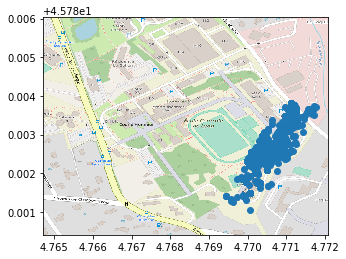

In [23]:
long_res,lat_res = selection_residence(long,lat)

datafile3 = 'carte_centrale_petite.png'
img3 = plt.imread(datafile3)

plt.scatter(long_res,lat_res)
plt.imshow(img3,zorder=0,extent = [4.76471,4.77209,45.78041,45.78603])
plt.show()